<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled281.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================
# BLOCK 1 — Imports + constants
# ============================

!pip install gemmi > /dev/null

import numpy as np
import math
from pathlib import Path
import gemmi
from scipy.linalg import expm
import matplotlib.pyplot as plt

# Fundamental constants
H_BAR = 6.582119569e-16   # eV*s
DT_FS = 0.02
DT_S  = DT_FS * 1e-15
N_STEPS_WIRE = 400

# YBCO registry (your final correct version)
YBCO_REGISTRY = {
    "1540950_optimal"   : "1540950.cif",
    "1540179_Opoor"     : "1540179.cif",
    "1516578_Cu_def"    : "1516578.cif",
    "1540951_Zn_doped"  : "1540951.cif",
    "1540952_nearO7b"   : "1540952.cif",
    "2107236_O654"      : "2107236.cif",
    "9007744_single_xtl": "9007744.cif",
    "1510239_Au_doped"  : "1510239.cif",
}

# wire parameters
N_UNITS_WIRE   = 10
K_LINK_DEFAULT = 2.0

# refined grid you used
A_vals_ref = np.linspace(0.1, 1.4, 9)
omega_vals_ref = np.linspace(0.2, 0.8, 9)

In [ ]:
!pip install gemmi pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 19.1 MB/s eta 0:00:00


In [ ]:
# ======================================
# BLOCK 2 — get_ybco_cuo_cluster()
# ======================================

def base_element(sym: str) -> str:
    return "".join(ch for ch in sym if ch.isalpha())

def get_ybco_cuo_cluster(cif_path: str):
    small = gemmi.read_small_structure(cif_path)
    cell  = small.cell
    coords_list  = []
    species_list = []

    for s in small.sites:
        el = base_element(s.type_symbol).upper()
        if el not in ("CU", "O"):
            continue

        if hasattr(s, "frac"):
            frac = s.frac
        elif hasattr(s, "fract"):
            frac = s.fract
        else:
            raise RuntimeError(f"Site in {cif_path} missing fractional coords")

        cart = cell.orthogonalize(frac)
        coords_list.append([float(cart.x), float(cart.y), float(cart.z)])
        species_list.append(el)

    coords = np.array(coords_list, float)
    species = np.array(species_list, object)

    cu_idx = [i for i,e in enumerate(species) if e=="CU"]
    if len(cu_idx) < 2:
        raise RuntimeError("Need ≥2 Cu sites")

    src_local = cu_idx[0]
    tgt_local = cu_idx[-1]

    return coords, species, src_local, tgt_local

In [ ]:
# ===========================================================
# BLOCK 3 — Hamiltonian builder + build_single_engine
# ===========================================================

BETA_E       = 1.0
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]
COMB_WIDTH   = 0.18

def resonance_comb(r):
    val = 0.0
    for c in COMB_CENTERS:
        val += math.exp(-(r - c)**2 / (2*COMB_WIDTH**2))
    return 1.0 + 1.5*(val/(len(COMB_CENTERS)+1e-9))

def build_hamiltonian_coppergate(coords, species, c1=0.90, c2=1.00):
    coords = np.asarray(coords,float)
    species = np.asarray(species,object)
    n = len(coords)
    H = np.zeros((n,n), complex)

    diag = np.array([2.0 if s=="CU" else 1.0 for s in species])
    np.fill_diagonal(H, diag)

    R = np.linalg.norm(coords[:,None]-coords[None,:], axis=2)
    T0 = 8.0
    beta = BETA_E * c2

    for i in range(n):
        for j in range(i+1,n):
            Tij = T0*np.exp(-beta*R[i,j])*resonance_comb(R[i,j])*c1
            H[i,j] = H[j,i] = Tij

    return H

def build_single_engine(label, cif, c1_nom=0.90, c2_nom=1.00):
    coords, species, src_local, tgt_local = get_ybco_cuo_cluster(cif)
    H_eng = build_hamiltonian_coppergate(coords, species, c1_nom, c2_nom)
    return H_eng, src_local, tgt_local, len(coords)

In [ ]:
# =====================================================
# BLOCK 4 — run_chain_tdse_driven()
# =====================================================

def run_chain_tdse_driven(H_chain_base, link_pairs, src_global,
                          n_sites_per_unit, num_units=N_UNITS_WIRE,
                          n_steps=N_STEPS_WIRE,
                          A_drive=0.5, omega=0.5):

    dim = H_chain_base.shape[0]
    psi = np.zeros(dim, complex)
    psi[src_global] = 1.0

    t_axis = np.arange(n_steps)*DT_FS
    P_units = np.zeros((num_units, n_steps), float)

    H0 = H_chain_base.copy()
    for (i,j) in link_pairs:
        H0[i,j] = H0[j,i] = 0.0

    K0 = [H_chain_base[i,j] for (i,j) in link_pairs]

    for k,t_fs in enumerate(t_axis):
        phase = np.cos(omega*t_fs)
        H_t = H0.copy()
        for idx,(i,j) in enumerate(link_pairs):
            H_t[i,j] = H_t[j,i] = K0[idx]*(1 + A_drive*phase)

        U_t = expm(-1j*H_t*(DT_S/H_BAR))

        p = np.abs(psi)**2
        for u in range(num_units):
            a = u*n_sites_per_unit
            b = a + n_sites_per_unit
            P_units[u,k] = p[a:b].sum()

        psi = U_t @ psi
        psi /= np.linalg.norm(psi) + 1e-12

    return t_axis, P_units

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------------------
# 0. CONFIG: which labels to treat as "doped" to mix with optimal
# --------------------------------------------------------------
OPT_LABEL = "1540950_optimal"
DOPED_LABELS = [
    "1510239_Au_doped",
    "1540179_Opoor",
    "1540951_Zn_doped",
    "1540952_nearO7b",
    "2107236_O654",
    "1516578_Cu_def",
    "9007744_single_xtl",
]

MIX_FRACTION = 0.20   # ~20% doped units in the chain
OUT_DIR = Path("mixed_20pct_results")
OUT_DIR.mkdir(exist_ok=True)

print("Using A_vals_ref:", A_vals_ref)
print("Using omega_vals_ref:", omega_vals_ref)
print("N_UNITS_WIRE:", N_UNITS_WIRE)
print("Mix fraction:", MIX_FRACTION)

# --------------------------------------------------------------
# 1. Helper: choose which units are doped vs optimal
# --------------------------------------------------------------
def make_unit_pattern(n_units, fraction_doped, rng_seed=123):
    """
    Returns a list of length n_units where each entry is either 'opt' or 'dop',
    with approximately fraction_doped of them set to 'dop'.
    """
    rng = np.random.default_rng(rng_seed)
    pattern = np.array(["opt"] * n_units, dtype=object)
    n_doped = max(1, int(round(fraction_doped * n_units)))
    doped_indices = rng.choice(n_units, size=n_doped, replace=False)
    pattern[doped_indices] = "dop"
    return pattern.tolist()

# --------------------------------------------------------------
# 2. Build mixed chain Hamiltonian from optimal + doped engines
# --------------------------------------------------------------
def build_mixed_chain_hamiltonian(label_opt, cif_opt,
                                  label_dop, cif_dop,
                                  fraction_doped=MIX_FRACTION,
                                  num_units=N_UNITS_WIRE,
                                  K_link=K_LINK_DEFAULT,
                                  rng_seed=123):
    """
    Build a chain Hamiltonian with num_units, each unit either 'opt' or 'dop',
    using the same c1_nom, c2_nom for both engines as in your uniform wires.
    """
    # build engines once
    H_opt, src_opt, tgt_opt, n_sites_opt = build_single_engine(label_opt, cif_opt, c1_nom=0.90, c2_nom=1.00)
    H_dop, src_dop, tgt_dop, n_sites_dop = build_single_engine(label_dop, cif_dop, c1_nom=0.90, c2_nom=1.00)

    # sanity: require same number of sites per engine
    if n_sites_opt != n_sites_dop:
        raise ValueError(f"Engine site counts differ ({n_sites_opt} vs {n_sites_dop}); "
                         f"cannot mix {label_opt} and {label_dop} in this simple model.")

    n_sites = n_sites_opt
    dim_chain = num_units * n_sites
    H_chain = np.zeros((dim_chain, dim_chain), dtype=np.complex128)

    # pattern of 'opt' vs 'dop' units
    pattern = make_unit_pattern(num_units, fraction_doped, rng_seed=rng_seed)
    print(f"[PATTERN] {label_opt} + {label_dop}:", pattern)

    # copy blocks
    engine_src_local = []
    engine_tgt_local = []
    for u, tag in enumerate(pattern):
        a = u * n_sites
        b = a + n_sites
        if tag == "opt":
            H_chain[a:b, a:b] = H_opt
            engine_src_local.append(src_opt)
            engine_tgt_local.append(tgt_opt)
        else:
            H_chain[a:b, a:b] = H_dop
            engine_src_local.append(src_dop)
            engine_tgt_local.append(tgt_dop)

    # add chain links between units, always linking "tgt" of unit u to "src" of unit u+1
    link_pairs = []
    for u in range(num_units - 1):
        src_local_u = engine_src_local[u+1]
        tgt_local_u = engine_tgt_local[u]
        i = u * n_sites + tgt_local_u
        j = (u+1) * n_sites + src_local_u
        H_chain[i, j] = H_chain[j, i] = K_link
        link_pairs.append((i, j))

    # define global injection indices:
    src_left  = engine_src_local[0]                    # first unit's source
    src_right = (num_units - 1) * n_sites + engine_tgt_local[-1]  # last unit's target

    return H_chain, src_left, src_right, n_sites, link_pairs, pattern

# --------------------------------------------------------------
# 3. Sweep (A, ω) for each mixed wire and save NPZ & PNG
# --------------------------------------------------------------
for dop_label in DOPED_LABELS:
    if dop_label == OPT_LABEL:
        continue

    cif_opt = YBCO_REGISTRY[OPT_LABEL]
    cif_dop = YBCO_REGISTRY[dop_label]

    print(f"\n[MIXED SWEEP] {OPT_LABEL} + 20% {dop_label}")
    try:
        Hc, src_left, src_right, n_sites, link_pairs, pattern = \
            build_mixed_chain_hamiltonian(
                OPT_LABEL, cif_opt,
                dop_label, cif_dop,
                fraction_doped=MIX_FRACTION,
                num_units=N_UNITS_WIRE,
                K_link=K_LINK_DEFAULT,
                rng_seed=123  # change for different random patterns
            )
    except Exception as e:
        print("  [ERROR building mixed chain]:", e)
        continue

    # allocate map
    R_map = np.zeros((len(A_vals_ref), len(omega_vals_ref)), float)

    for i, A in enumerate(A_vals_ref):
        for j, w in enumerate(omega_vals_ref):
            print(f"  [TDSE] A={A:.2f}, ω={w:.2f}")
            # LEFT injection
            _, P_L = run_chain_tdse_driven(
                Hc, link_pairs, src_left,
                n_sites, num_units=N_UNITS_WIRE,
                n_steps=N_STEPS_WIRE,
                A_drive=A, omega=w
            )
            # RIGHT injection
            _, P_R = run_chain_tdse_driven(
                Hc, link_pairs, src_right,
                n_sites, num_units=N_UNITS_WIRE,
                n_steps=N_STEPS_WIRE,
                A_drive=A, omega=w
            )

            eta_L = float(P_L[-1].max())
            eta_R = float(P_R[0].max())
            R_map[i, j] = eta_L / (eta_R + 1e-12)

    # ---- save NPZ ----
    mix_tag = f"mixed_{OPT_LABEL}_plus_{dop_label}_20pct"
    npz_path = OUT_DIR / f"{mix_tag}_A{A_vals_ref.min():.2f}-{A_vals_ref.max():.2f}_w{omega_vals_ref.min():.2f}-{omega_vals_ref.max():.2f}_9x9.npz"
    np.savez(
        npz_path,
        label_mix=mix_tag,
        base_label=OPT_LABEL,
        doped_label=dop_label,
        pattern=np.array(pattern, dtype=object),
        R_map=R_map,
        A_vals_ref=A_vals_ref,
        omega_vals_ref=omega_vals_ref,
        N_UNITS_WIRE=N_UNITS_WIRE,
        N_STEPS_WIRE=N_STEPS_WIRE
    )
    print(f"[SAVED NPZ] → {npz_path}")

    # ---- quick PNG plot ----
    plt.figure(figsize=(6,5))
    plt.imshow(
        R_map,
        origin="lower",
        extent=[omega_vals_ref.min(), omega_vals_ref.max(),
                A_vals_ref.min(),    A_vals_ref.max()],
        aspect="auto",
        cmap="inferno",
        interpolation="bilinear"
    )
    plt.colorbar(label=r"$\eta_L/\eta_R$")
    plt.xlabel(r"$\omega$ (fs$^{-1}$)")
    plt.ylabel(r"$A_{\mathrm{drive}}$")
    plt.title(f"Diodicity (20% {dop_label} in {OPT_LABEL} chain)")
    plt.tight_layout()

    png_path = OUT_DIR / f"{mix_tag}_panel.png"
    plt.savefig(png_path, dpi=300)
    plt.close()
    print(f"[SAVED PNG] → {png_path}")

Using A_vals_ref: [0.1    0.2625 0.425  0.5875 0.75   0.9125 1.075  1.2375 1.4   ]
Using omega_vals_ref: [0.2   0.275 0.35  0.425 0.5   0.575 0.65  0.725 0.8  ]
N_UNITS_WIRE: 10
Mix fraction: 0.2

[MIXED SWEEP] 1540950_optimal + 20% 1510239_Au_doped
[PATTERN] 1540950_optimal + 1510239_Au_doped: ['dop', 'opt', 'opt', 'opt', 'opt', 'opt', 'dop', 'opt', 'opt', 'opt']
  [TDSE] A=0.10, ω=0.20
  [TDSE] A=0.10, ω=0.28
  [TDSE] A=0.10, ω=0.35
  [TDSE] A=0.10, ω=0.43
  [TDSE] A=0.10, ω=0.50
  [TDSE] A=0.10, ω=0.58
  [TDSE] A=0.10, ω=0.65
  [TDSE] A=0.10, ω=0.73
  [TDSE] A=0.10, ω=0.80
  [TDSE] A=0.26, ω=0.20
  [TDSE] A=0.26, ω=0.28
  [TDSE] A=0.26, ω=0.35
  [TDSE] A=0.26, ω=0.43
  [TDSE] A=0.26, ω=0.50
  [TDSE] A=0.26, ω=0.58
  [TDSE] A=0.26, ω=0.65
  [TDSE] A=0.26, ω=0.73
  [TDSE] A=0.26, ω=0.80
  [TDSE] A=0.42, ω=0.20
  [TDSE] A=0.42, ω=0.28
  [TDSE] A=0.42, ω=0.35
  [TDSE] A=0.42, ω=0.43
  [TDSE] A=0.42, ω=0.50
  [TDSE] A=0.42, ω=0.58
  [TDSE] A=0.42, ω=0.65
  [TDSE] A=0.42, ω=0.73
  [TDSE] 

In [ ]:
import numpy as np
from matplotlib.colors import ListedColormap

icefire_data = np.array([
    [0.062,0.062,0.188],
    [0.120,0.062,0.329],
    [0.180,0.070,0.470],
    [0.239,0.090,0.611],
    [0.298,0.129,0.752],
    [0.357,0.190,0.886],
    [0.416,0.274,0.989],
    [0.470,0.380,0.999],
    [0.518,0.499,0.999],
    [0.556,0.619,0.999],
    [0.587,0.739,0.999],
    [0.612,0.860,0.999],
    [0.630,0.980,0.999],
    [0.631,0.999,0.896],
    [0.631,0.999,0.751],
    [0.621,0.999,0.606],
    [0.591,0.999,0.462],
    [0.541,0.999,0.318],
    [0.470,0.999,0.182],
    [0.380,0.999,0.091],
    [0.270,0.999,0.039],
    [0.149,0.999,0.015],
    [0.030,0.999,0.015],
    [0.015,0.999,0.129],
    [0.015,0.999,0.267],
    [0.015,0.999,0.408],
    [0.015,0.999,0.549],
    [0.021,0.999,0.690],
    [0.066,0.999,0.830],
    [0.145,0.999,0.965],
    [0.259,0.969,0.999],
    [0.380,0.910,0.999],
    [0.499,0.830,0.999],
    [0.619,0.730,0.999],
    [0.739,0.610,0.999],
    [0.860,0.470,0.999],
    [0.980,0.310,0.999],
    [0.999,0.129,0.980],
    [0.999,0.090,0.820],
    [0.999,0.070,0.660],
    [0.999,0.070,0.500],
    [0.999,0.090,0.340],
    [0.999,0.149,0.200],
    [0.999,0.239,0.090],
    [0.999,0.360,0.015],
    [0.999,0.499,0.015],
    [0.999,0.639,0.015],
    [0.999,0.780,0.039],
    [0.999,0.921,0.129]
])
cmap_icefire = ListedColormap(icefire_data, name="icefire")
print("cmap_icefire defined.")

cmap_icefire defined.


In [ ]:
import zipfile
from pathlib import Path

root = Path("positional_20pct_results")
npz_files = sorted(root.glob("*.npz"))

print(f"Found {len(npz_files)} NPZ files in {root}")

zip_path = Path("positional_20pct_npz.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in npz_files:
        zf.write(f, arcname=f.name)
        print("  added:", f.name)

print("\n[INFO] Zipped NPZs to:", zip_path)
print("You can now download", zip_path)

Found 0 NPZ files in positional_20pct_results

[INFO] Zipped NPZs to: positional_20pct_npz.zip
You can now download positional_20pct_npz.zip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

root = Path("positional_20pct_results")
npz_files = sorted(root.glob("*.npz"))

maps = {}   # (i,j) -> dict(R_map, A_vals, w_vals)

for f in npz_files:
    data = np.load(f, allow_pickle=True)
    if "R_map" not in data or "dop_positions" not in data:
        continue
    R = data["R_map"]
    A_vals = data["A_vals"]
    w_vals = data["w_vals"]
    dop_pos = data["dop_positions"]
    # ensure sorted tuple (i,j)
    dop_pos = tuple(sorted(int(x) for x in dop_pos))
    maps[dop_pos] = dict(R=R, A=A_vals, w=w_vals)

print(f"[INFO] Loaded {len(maps)} positional maps.")
# Infer wire length from max dopant index
N_UNITS = max(max(p) for p in maps.keys())
print("Inferred N_UNITS =", N_UNITS)

[INFO] Loaded 45 positional maps.
Inferred N_UNITS = 10


Global η_L/η_R range: 0.0022807488782285957 → 9.916378324442022


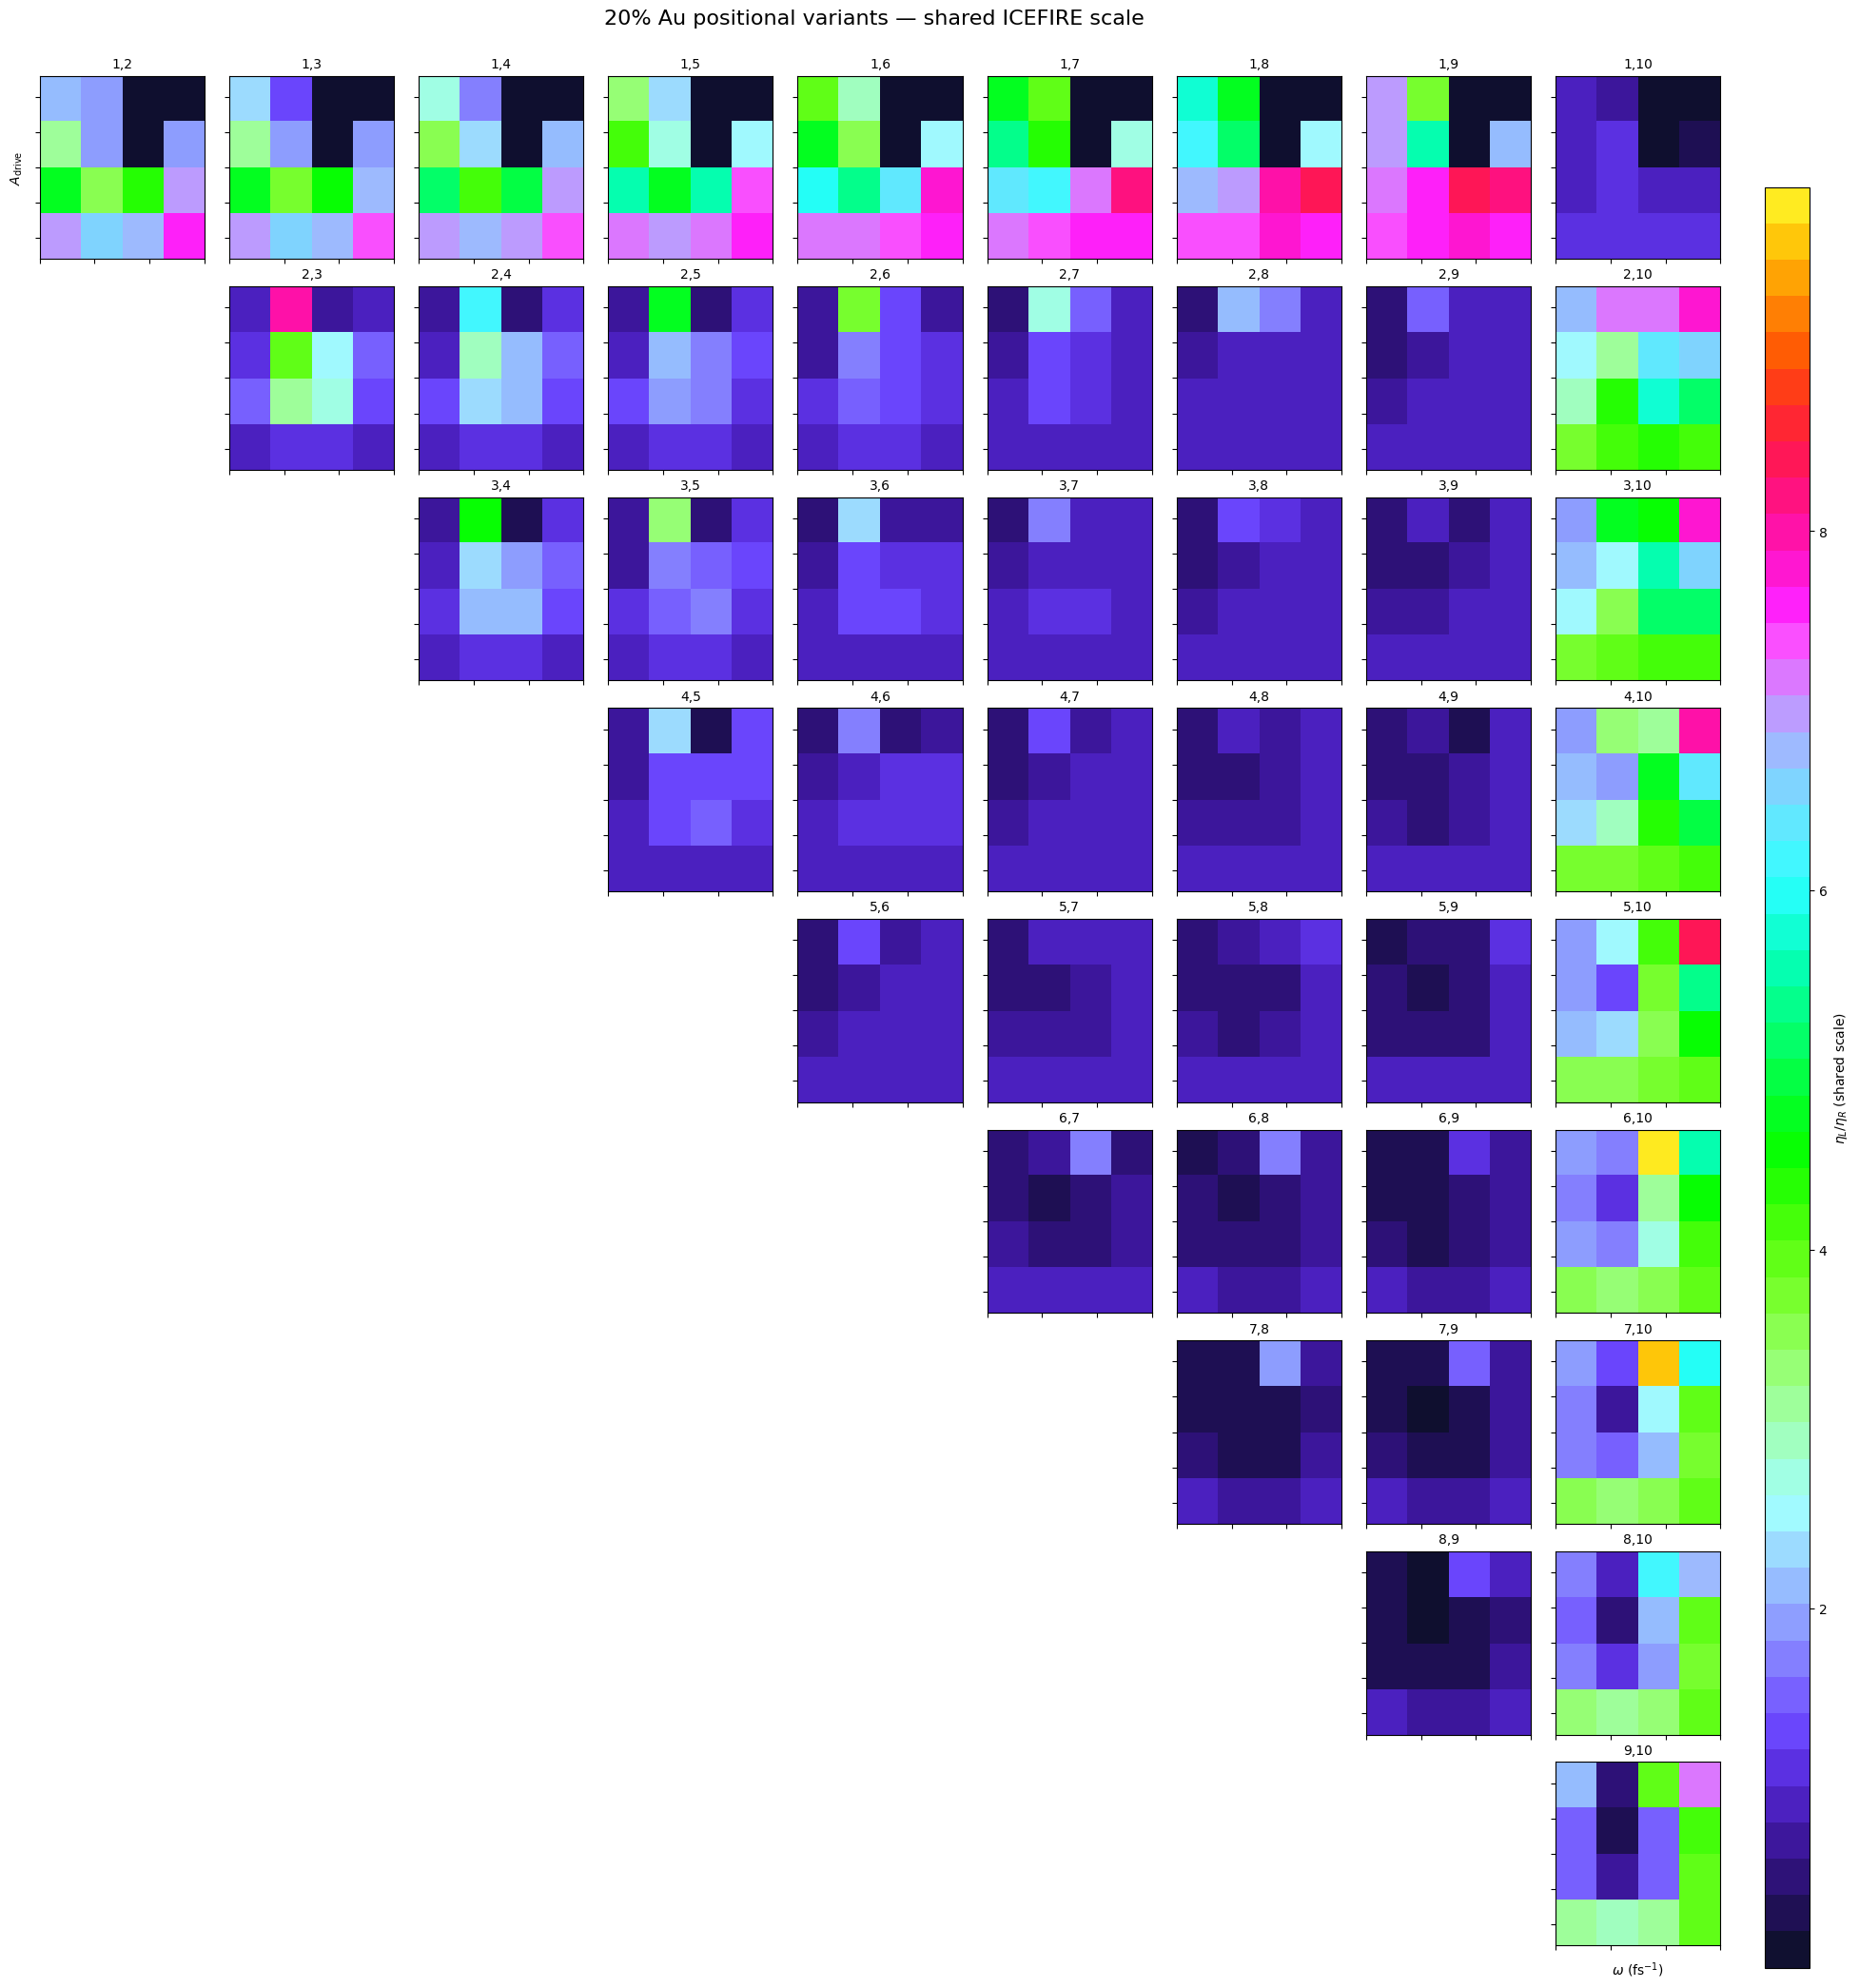

In [ ]:
# --- compute global vmin/vmax across all R_maps ---
all_vals = []
for k, v in maps.items():
    R = v["R"]
    all_vals.append(R.ravel())
all_vals = np.concatenate(all_vals)
global_vmin = float(np.nanmin(all_vals))
global_vmax = float(np.nanmax(all_vals))

print("Global η_L/η_R range:", global_vmin, "→", global_vmax)

# use ICEFIRE if available
this_cmap = cmap_icefire if "cmap_icefire" in globals() else "inferno"

# --- make figure: 9×9 grid for (i,j) with i<j ---
nrows = N_UNITS - 1  # 1..9 along rows (i)
ncols = N_UNITS - 1  # 2..10 along cols (j)
fig, axes = plt.subplots(nrows, ncols, figsize=(2.6*ncols, 2.6*nrows),
                         sharex=True, sharey=True)

# ensure axes is 2D array
axes = np.atleast_2d(axes)

for i in range(1, N_UNITS):       # i = 1..9
    for j in range(2, N_UNITS+1): # j = 2..10
        ax = axes[i-1, j-2]
        if j <= i:
            ax.axis("off")
            continue

        key = (i, j)
        if key not in maps:
            ax.axis("off")
            continue

        R = maps[key]["R"]
        A = maps[key]["A"]
        w = maps[key]["w"]

        im = ax.imshow(
            R,
            origin="lower",
            extent=[w.min(), w.max(), A.min(), A.max()],
            aspect="auto",
            vmin=global_vmin,
            vmax=global_vmax,
            cmap=this_cmap
        )
        ax.set_title(f"{i},{j}", fontsize=10)

        # Only label leftmost column & bottom row to avoid clutter
        if j == 2:
            ax.set_ylabel(r"$A_{\rm drive}$")
        else:
            ax.set_yticklabels([])

        if i == nrows:
            ax.set_xlabel(r"$\omega$ (fs$^{-1}$)")
        else:
            ax.set_xticklabels([])

fig.subplots_adjust(right=0.88, top=0.95, hspace=0.15, wspace=0.15)
cax = fig.add_axes([0.90, 0.10, 0.02, 0.80])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\eta_L/\eta_R$ (shared scale)")

fig.suptitle("20% Au positional variants — shared ICEFIRE scale", fontsize=16)
plt.show()

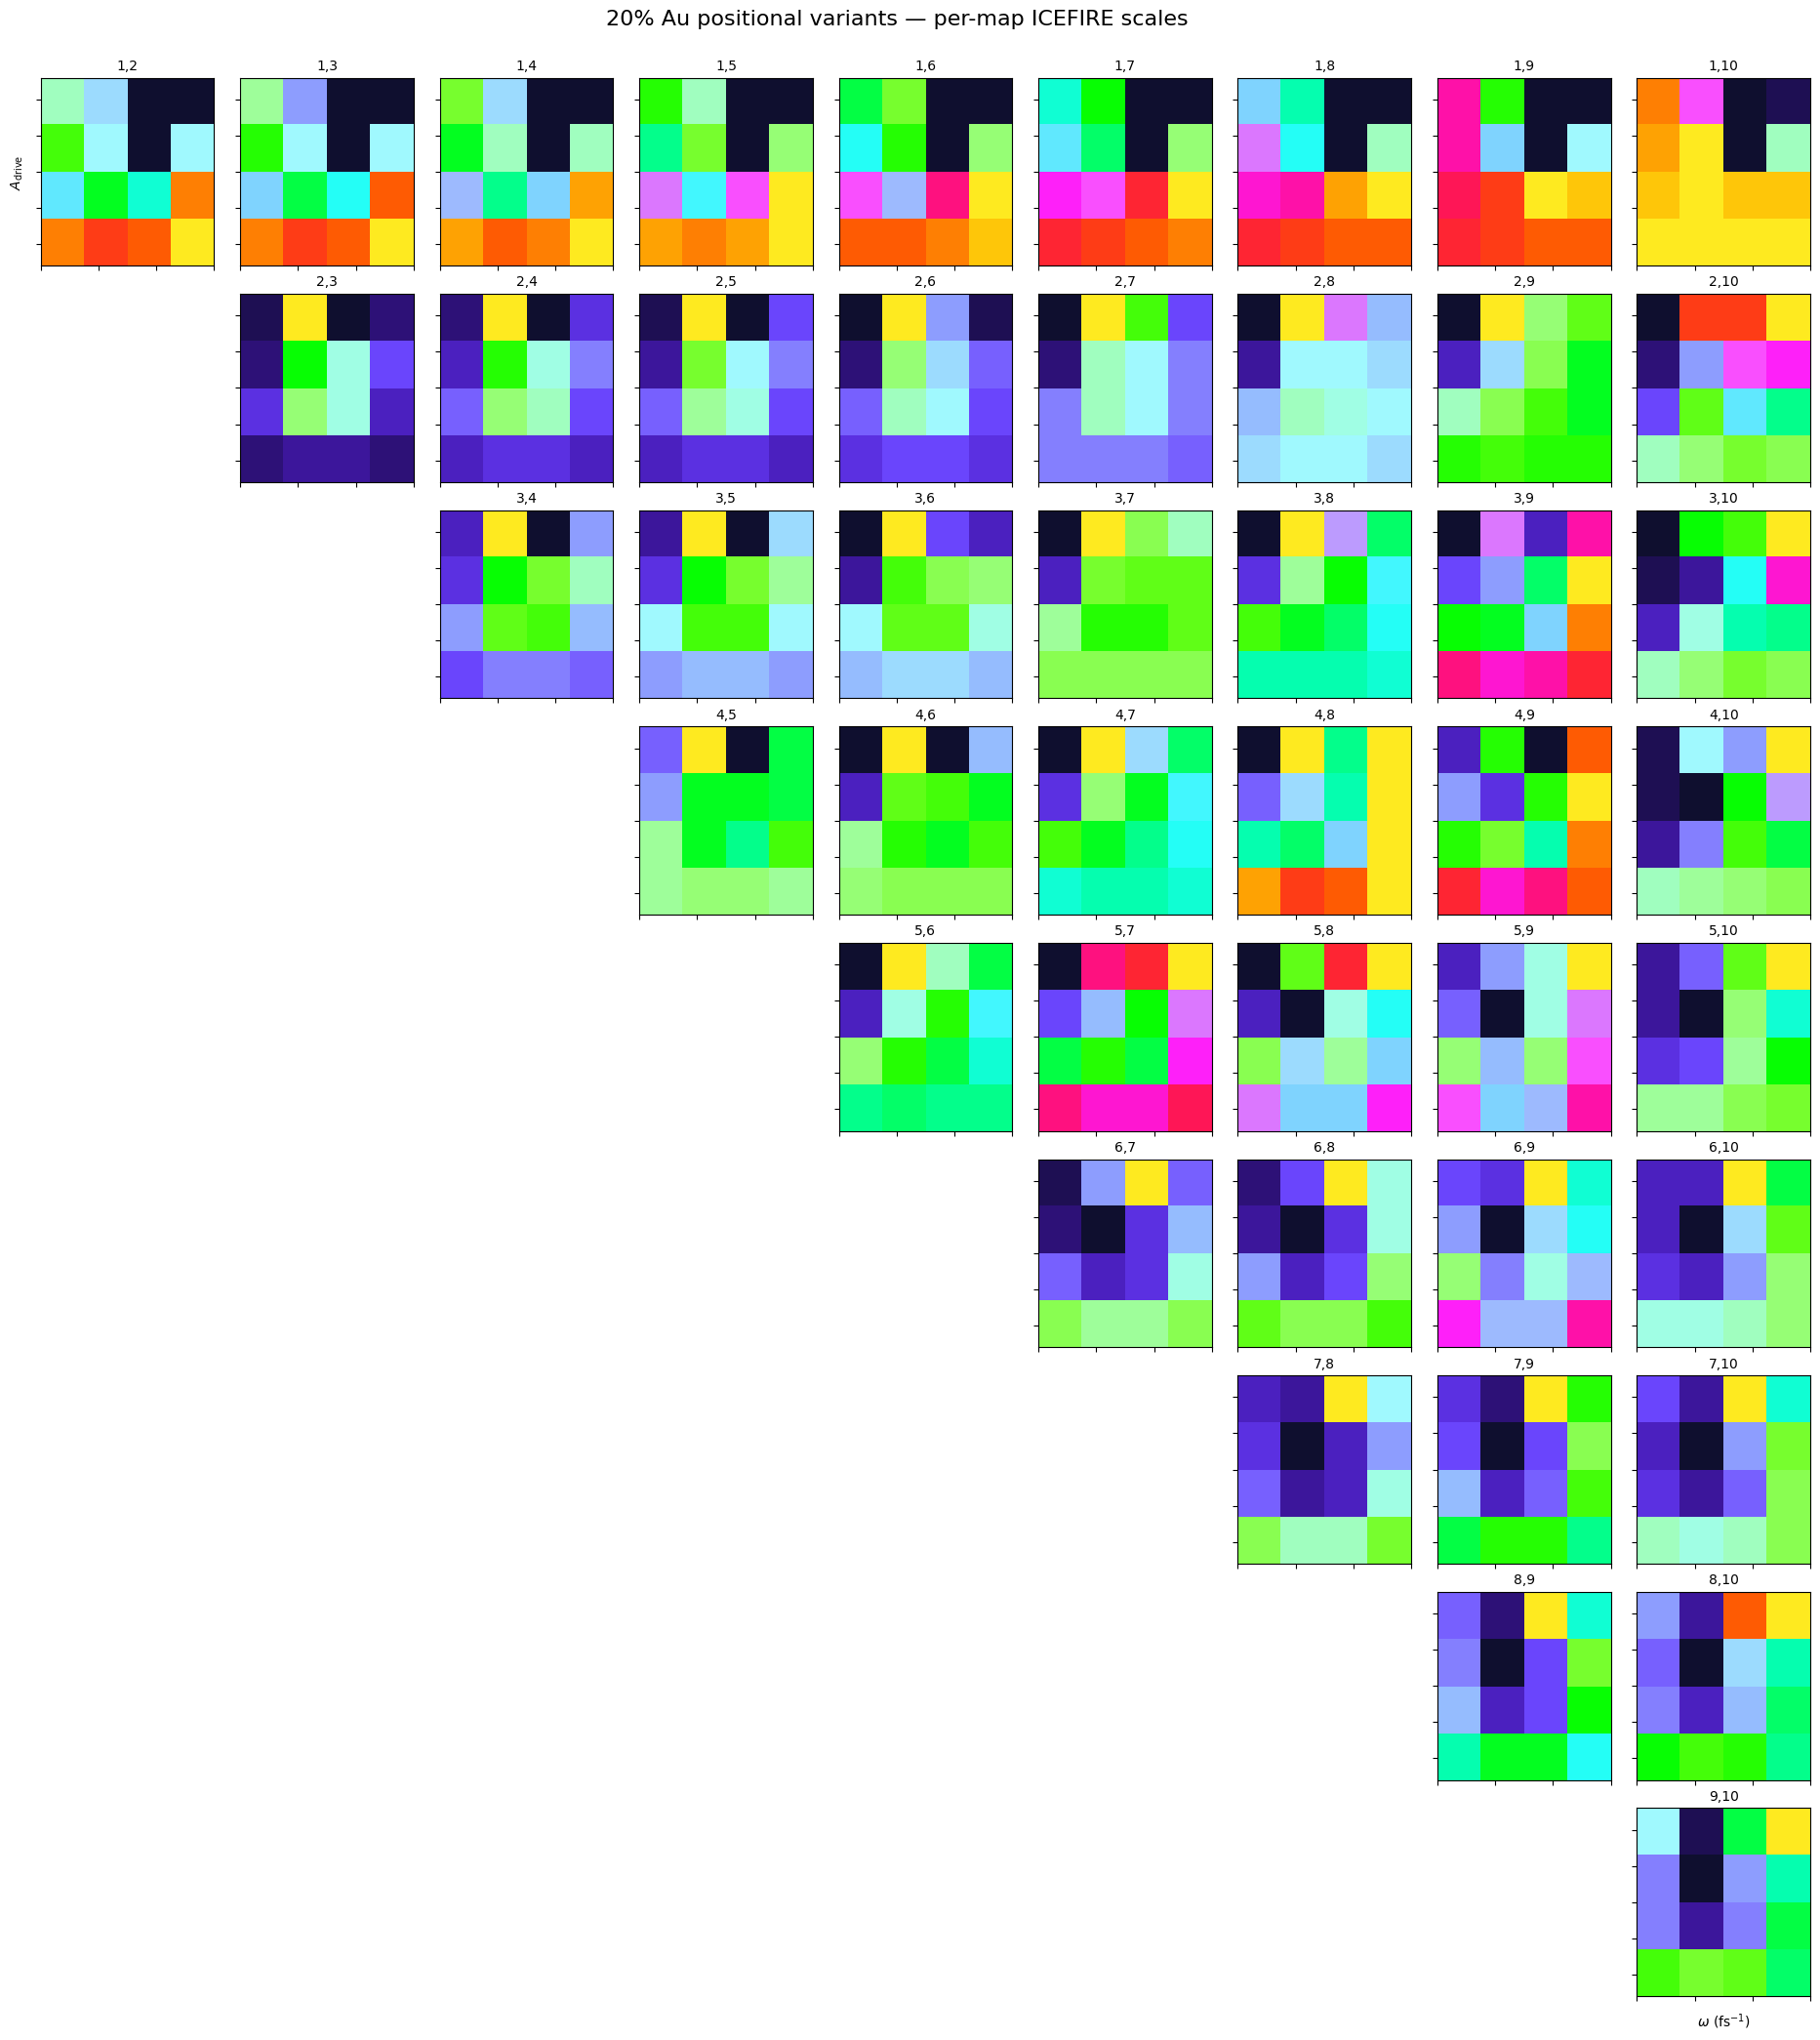

In [ ]:
fig, axes = plt.subplots(nrows, ncols, figsize=(2.6*ncols, 2.6*nrows),
                         sharex=True, sharey=True)
axes = np.atleast_2d(axes)

for i in range(1, N_UNITS):       # i = 1..9
    for j in range(2, N_UNITS+1): # j = 2..10
        ax = axes[i-1, j-2]
        if j <= i:
            ax.axis("off")
            continue

        key = (i, j)
        if key not in maps:
            ax.axis("off")
            continue

        R = maps[key]["R"]
        A = maps[key]["A"]
        w = maps[key]["w"]

        im = ax.imshow(
            R,
            origin="lower",
            extent=[w.min(), w.max(), A.min(), A.max()],
            aspect="auto",
            cmap=this_cmap  # per-map color scaling
        )
        ax.set_title(f"{i},{j}", fontsize=10)

        if j == 2:
            ax.set_ylabel(r"$A_{\rm drive}$")
        else:
            ax.set_yticklabels([])

        if i == nrows:
            ax.set_xlabel(r"$\omega$ (fs$^{-1}$)")
        else:
            ax.set_xticklabels([])

# no global colorbar because each map has its own scale
fig.subplots_adjust(top=0.95, hspace=0.15, wspace=0.15)
fig.suptitle("20% Au positional variants — per-map ICEFIRE scales", fontsize=16)
plt.show()